In [1]:
import pandas as pd
import numpy as np
from sklearn import cluster
from sklearn import manifold
import matplotlib.pyplot as plt
import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D
from sklearn import preprocessing
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import random
pd.set_option('display.max_rows', 1000)

In [49]:
glass_data = pd.read_csv("material_data/Glass Sim Correction.csv")
concrete_data = pd.read_csv("material_data/Concrete Sim Correction.csv")
metal_data = pd.read_csv("material_data/Metal Sim Correction.csv")
plastic_data = pd.read_csv("material_data/Plastic Sim Correction.csv")
wood_data = pd.read_csv("material_data/Wood Sim Correction.csv")

In [50]:
print(glass_data.shape)
print(plastic_data.shape)

(3765, 8)
(3765, 8)


In [51]:
glass_data = glass_data.dropna()
concrete_data = concrete_data.dropna()
metal_data = metal_data.dropna()
plastic_data = plastic_data.dropna()
wood_data = wood_data.dropna()

In [52]:
recv_num = []
#labels = ['glass','concrete','metal','plastic','wood']
label = np.array([0]*glass_data.shape[0])
for i in range(0,glass_data.shape[0],250):
    recv_num.extend([int(i/250+1)]*250)

In [53]:
glass_data.insert(0, 'Label', label) # label = 0
glass_data.insert(1, 'Receiver', recv_num)
concrete_data.insert(0, 'Label', label+1) # label = 1
concrete_data.insert(1, 'Receiver', recv_num)
metal_data.insert(0, 'Label', label+2) # label = 2
metal_data.insert(1, 'Receiver', recv_num)
plastic_data.insert(0, 'Label', label+3) # label = 3
plastic_data.insert(1, 'Receiver', recv_num)
wood_data.insert(0, 'Label', label+4) # label = 4
wood_data.insert(1, 'Receiver', recv_num)

In [54]:
# combining all the dataframes
data = pd.concat([glass_data,concrete_data,metal_data,plastic_data,wood_data])
data.head(10)

,Label,Receiver,Path Number,Phase Value (deg),Mean Time of Arrival (sec),Received Power (dBm),Arrival phi (deg),Arrival Theta (deg),Departure phi (deg),Departure Theta (deg)
1,0,1,1,167.793000,6.673440e-09,-60.7748,-1.800000e+02,180.0000,0.0000,180.0000
2,0,1,2,137.038000,6.673440e-08,-63.9429,-1.015600e-12,90.0000,-180.0000,90.0000
3,0,1,3,-147.860000,1.334690e-08,-66.8587,-1.800000e+02,0.0000,0.0000,0.0000
4,0,1,4,-163.935000,6.706720e-08,-67.2093,-1.015600e-12,95.7106,-180.0000,95.7106
5,0,1,5,-17.418600,6.708400e-08,-69.0276,5.852180e+00,90.0000,174.1480,90.0000
6,0,1,6,-0.994874,6.854330e-09,-70.0943,8.629960e+01,90.0000,86.2996,90.0000
7,0,1,7,171.016000,4.665700e-08,-70.8370,-9.000000e+01,90.0000,-90.0000,90.0000
8,0,1,8,-100.859000,6.967280e-08,-71.1223,-1.015230e-12,106.6990,-180.0000,73.3008
9,0,1,9,5.169440,1.201220e-07,-72.8922,8.751430e-12,90.0000,180.0000,90.0000
10,0,1,10,109.542000,1.203070e-07,-73.8282,8.751430e-12,93.1798,180.0000,93.1798


In [55]:
path_length = []
c = 299792458 #speed of light
data_iter = data.iterrows()
for i in range(data.shape[0]):
    row = next(data_iter)
    length = row[1]['Mean Time of Arrival (sec)']*c
    path_length.append(length)
data.insert(3, 'Path Length (m)', path_length)

In [56]:
#filtering out the rows with 90 arrival and departure theta
trimmed_data = data[(data['Departure Theta (deg)']==90) & (data['Departure phi (deg)']==90)
                         & (data['Arrival Theta (deg)']==90) & (data['Arrival phi (deg)']==90) & (data['Path Length (m)']<15)
                    & ((data['Receiver']==2) | (data['Receiver']==3) | (data['Receiver']==4) | (data['Receiver']==5) | (data['Receiver']==8)
                      | (data['Receiver']==9) | (data['Receiver']==10) | (data['Receiver']==13) | (data['Receiver']==14) | (data['Receiver']==15))
trimmed_data.shape

(49, 11)

In [151]:
trimmed_data = trimmed_data.reset_index(drop=True)
test_data = pd.DataFrame(columns=trimmed_data.columns)
idx = []
for i in range(0,len(trimmed_data),4):
    #rand = random.randint(0, 3)
    #random_idx.append(rand)
    #train_data = trimmed_data.drop(rand+i)
    train_data = trimmed_data.drop(i)
    idx.append(i)
    #train_data = trimmed_data.drop(i+1)
train_data = train_data.reset_index(drop=True)
train_data = train_data.iloc[:,[0,1,3,5,6]]
test_data = trimmed_data.iloc[idx,[0,1,3,5,6]] 

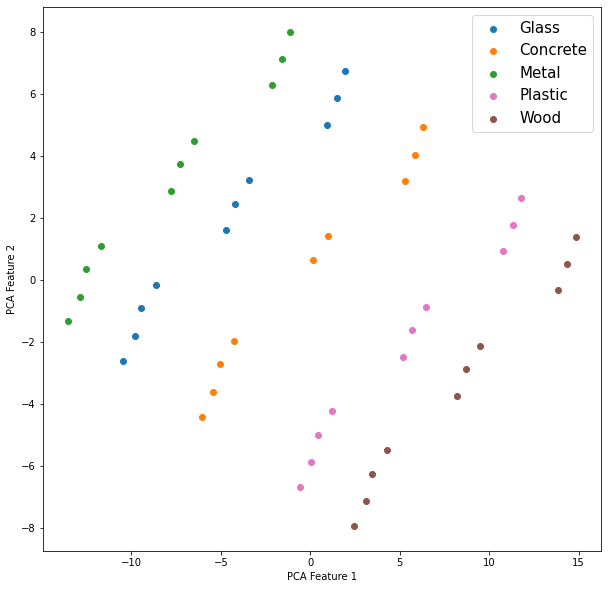

In [165]:
from sklearn.decomposition import PCA
#df = data[(data['Label']==0)]
#tsne = manifold.TSNE(n_components=2,n_iter=5000,perplexity = 60)
#trans_tsne = tsne.fit_transform(train_data.iloc[:,1:])
#transforming the featurs using the train data
pca = PCA(n_components=2).fit(train_data.iloc[:,1:]) # generating a tranformation matrix based on the training data only
train_labels = train_data.iloc[:,0]
trans_pca = pca.transform(trimmed_data.iloc[:,[1,3,5,6]]) # transforming all the data including test data (just to plot)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:pink','tab:brown']
classes = ['Glass','Concrete','Metal','Plastic','Wood']
labels = np.array(trimmed_data['Label'])
scatter = []
for i in range(len(names)):
    a = trans_pca[trimmed_data['Label'] == i]
    scatter.append(ax.scatter(a[:,0],a[:,1], color = colors[i], label = classes[i]))

ax.legend(loc='upper right',fontsize=15)
ax.set_xlabel('PCA Feature 1')
ax.set_ylabel('PCA Feature 2')
plt.show()

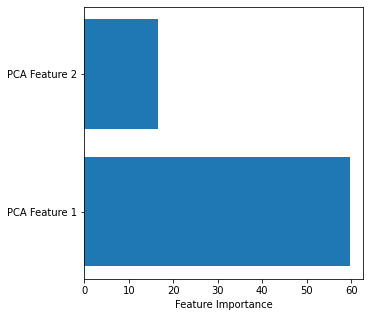

In [111]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.barh([1,2],pca.explained_variance_,tick_label = ['PCA Feature 1','PCA Feature 2'])
ax.set_xlabel('Feature Importance')
plt.show()

In [162]:
clf = svm.SVC(decision_function_shape='ovr')
clf.fit(pca.transform(train_data.iloc[:,1:]), train_labels) #training classifier

test_pred = clf.predict(pca.transform(test_data.iloc[:,1:]))
test_labels = test_data.iloc[:,0]
accuracy_score(test_labels, test_pred)

1.0

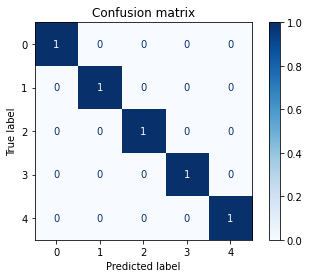

In [164]:
from sklearn.metrics import plot_confusion_matrix
matrix = plot_confusion_matrix(clf, pca.transform(test_data.iloc[:,1:]), test_labels,cmap=plt.cm.Blues,normalize='true')
plt.title('Confusion matrix')
plt.show(matrix)
plt.show()